Set parameter Username
Set parameter LicenseID to value 2653942
Academic license - for non-commercial use only - expires 2026-04-17
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 3366 rows, 2106 columns and 7145 nonzeros
Model fingerprint: 0x9d62d594
Model has 421 quadratic constraints
Variable types: 1264 continuous, 842 integer (842 binary)
Coefficient statistics:
  Matrix range     [1e-05, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e-03, 1e-03]
  Bounds range     [1e+00, 1e+04]
  RHS range        [6e-03, 9e+01]
Presolve removed 2423 rows and 742 columns
Presolve time: 0.24s
Presolved: 2203 rows, 2624 columns, 6185 nonzeros
Presolved model has 840 SOS constraint(s)
Variable types: 1784 continuous, 840 integer

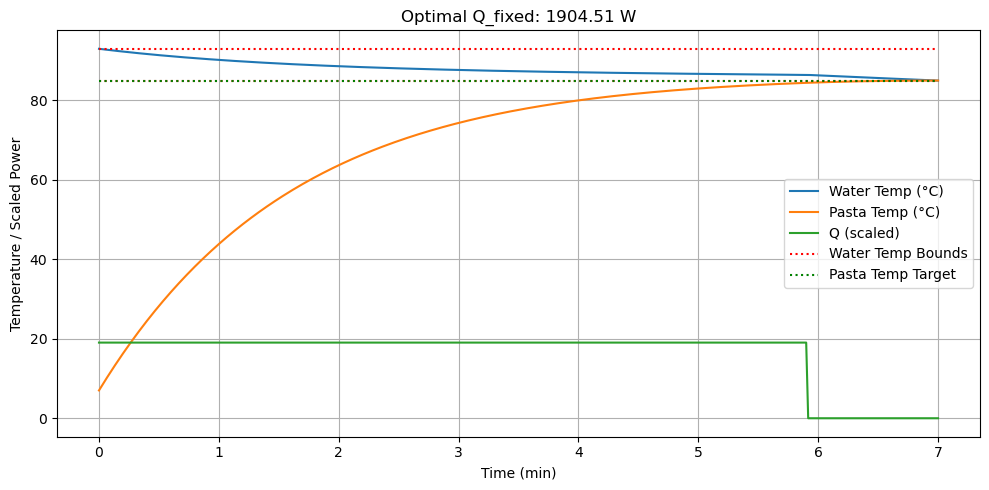

In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Constants
tc_s = 7 * 60        # total cooking time [s]
dt = 1               # time step [s]
n = int(tc_s / dt) + 1
T_env = 20
T_water_0 = 93
T_pasta_0 = 7

R_env = 30 / 1000    # [K/W]
R_pasta = 15 / 1000  # [K/W]
c_l = 4.18 * 1000    # [J/kg·K]
c_pasta = 3.5 * 1000 # [J/kg·K]

V_water = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1e6  # m^3
m_water = V_water * 1000
m_pasta = 2

C_water = m_water * c_l
C_pasta = m_pasta * c_pasta

t = np.linspace(0, tc_s, n)

# Initialize model
model = gp.Model("HeatPumpCooking")

# Variables
Q_fixed = model.addVar(lb=0, ub=10000, name="Q_fixed")
z = model.addVars(n, vtype=GRB.BINARY, name="z")
Q = model.addVars(n, lb=0, name="Q")

delta_on = model.addVars(n,vtype=GRB.BINARY, name = "delta_on")

T_water = model.addVars(n, lb=0, name="T_water")
T_pasta = model.addVars(n, lb=0, name="T_pasta")

# Initial conditions
model.addConstr(T_water[0] == T_water_0)
model.addConstr(T_pasta[0] == T_pasta_0)

#enforce that the heatpump is only turned on once
for t in range(1,n):
    model.addConstr(delta_on[t] >= z[t] - z[t-1])
    model.addConstr(delta_on[t] >= 0)
    model.addConstr(delta_on[t] <= 1)
    
model.addConstr(gp.quicksum(delta_on[t] for t in range(1,n))<=1)
for t in range(1,n):
    model.addConstr(z[t]<=z[t-1])

# Link Q to Q_fixed and z
for i in range(n):
    model.addConstr(Q[i] == Q_fixed * z[i])

# Temperature dynamics
for i in range(1, n):
    model.addConstr(
        T_water[i] == T_water[i - 1] + dt * (
            Q[i - 1] - (T_water[i - 1] - T_env) / R_env - (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
        ) / C_water
    )
    model.addConstr(
        T_pasta[i] == T_pasta[i - 1] + dt * (
            (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
        ) / C_pasta
    )

# Constraints:
# Water temperature must stay between 85 and 93°C
for i in range(n):
    model.addConstr(T_water[i] >= 85)
    model.addConstr(T_water[i] <= 93)

# Pasta must reach 85°C at the end
model.addConstr(T_pasta[n - 1] >= 85)

# Objective: minimize total energy (in kJ)
model.setObjective(gp.quicksum(Q[i] * dt for i in range(n)) / 1000, GRB.MINIMIZE)

# Solve
model.setParam("OutputFlag", 1)

model.optimize()

# Extract results
Q_vals = np.array([Q[i].X for i in range(n)])
T_water_vals = np.array([T_water[i].X for i in range(n)])
T_pasta_vals = np.array([T_pasta[i].X for i in range(n)])
Q_fixed_val = Q_fixed.X
t = np.linspace(0, tc_s, n)

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(t / 60, T_water_vals, label="Water Temp (°C)")
plt.plot(t / 60, T_pasta_vals, label="Pasta Temp (°C)")
plt.plot(t / 60, Q_vals / 100, label="Q (scaled)")
plt.hlines([85, 93], 0, tc_s / 60, colors='r', linestyles='dotted', label="Water Temp Bounds")
plt.hlines([85], 0, tc_s / 60, colors='g', linestyles='dotted', label="Pasta Temp Target")
plt.xlabel("Time (min)")
plt.ylabel("Temperature / Scaled Power")
plt.legend()
plt.grid()
plt.title(f"Optimal Q_fixed: {Q_fixed_val:.2f} W")
plt.tight_layout()
plt.show()


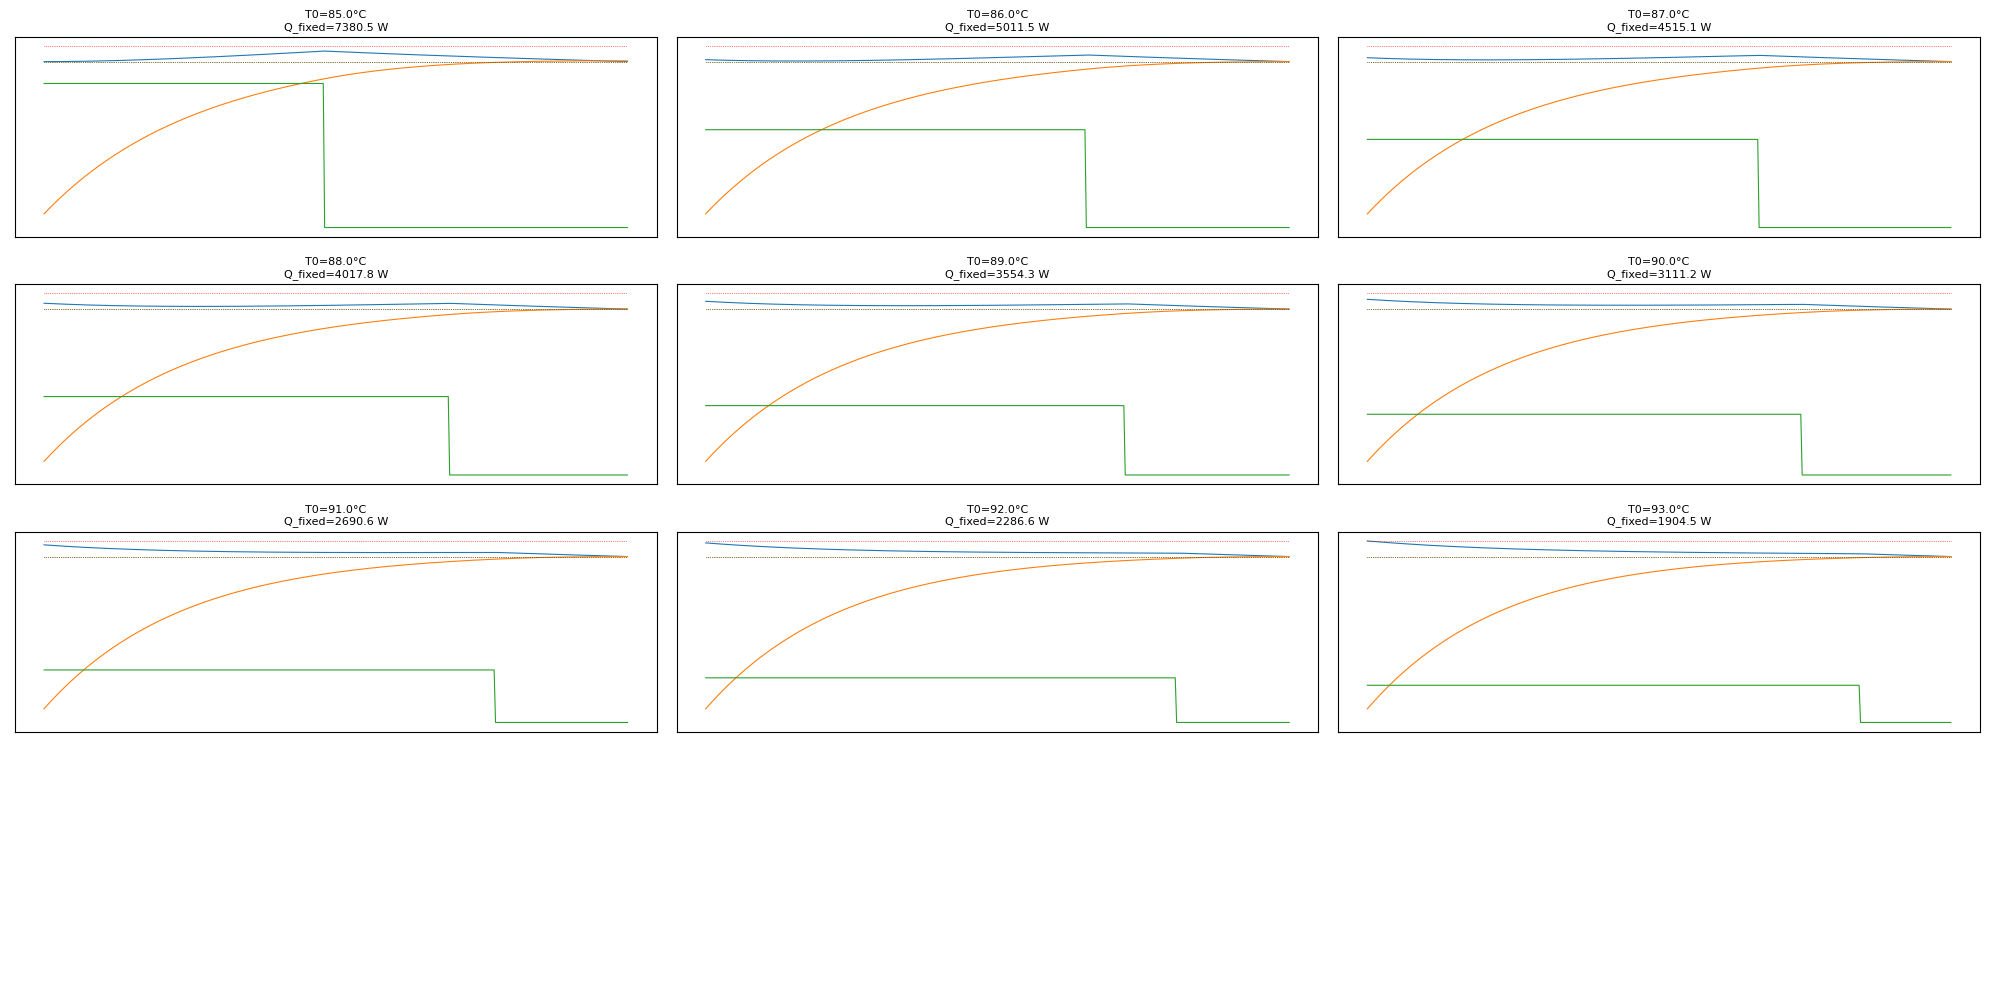

(array([85., 86., 87., 88., 89., 90., 91., 92., 93.]),
 [7380.504222806427,
  5011.508944254124,
  4515.059984119313,
  4017.8408744867484,
  3554.328915976963,
  3111.2449497921625,
  2690.5978507524414,
  2286.6288737152645,
  1904.5114525695099])

In [2]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Constants
tc_s = 7 * 60        # total cooking time [s]
dt = 1               # time step [s]
n = int(tc_s / dt) + 1
T_env = 20
T_pasta_0 = 7

R_env = 30 / 1000    # [K/W]
R_pasta = 15 / 1000  # [K/W]
c_l = 4.18 * 1000    # [J/kg·K]
c_pasta = 3.5 * 1000 # [J/kg·K]

V_water = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1e6  # m^3
m_water = V_water * 1000
m_pasta = 2

C_water = m_water * c_l
C_pasta = m_pasta * c_pasta

t = np.linspace(0, tc_s, n)
T_water_0_range = np.arange(85.0, 93.1, 1)
Q_fixed_values = []
fig, axs = plt.subplots(4, int(np.ceil(len(T_water_0_range) / 4)), figsize=(20, 10))
axs = axs.flatten()

for idx, T_water_0 in enumerate(T_water_0_range):
    model = gp.Model("HeatPumpCooking")
    model.setParam("OutputFlag", 0)

    Q_fixed = model.addVar(lb=0, ub=10000, name="Q_fixed")
    z = model.addVars(n, vtype=GRB.BINARY, name="z")
    Q = model.addVars(n, lb=0, name="Q")
    delta_on = model.addVars(n, vtype=GRB.BINARY, name="delta_on")
    T_water = model.addVars(n, lb=0, name="T_water")
    T_pasta = model.addVars(n, lb=0, name="T_pasta")

    model.addConstr(T_water[0] == T_water_0)
    model.addConstr(T_pasta[0] == T_pasta_0)

    for t_ in range(1, n):
        model.addConstr(delta_on[t_] >= z[t_] - z[t_-1])
        model.addConstr(delta_on[t_] >= 0)
        model.addConstr(delta_on[t_] <= 1)
        model.addConstr(z[t_] <= z[t_-1])

    model.addConstr(gp.quicksum(delta_on[t_] for t_ in range(1, n)) <= 1)

    for i in range(n):
        model.addConstr(Q[i] == Q_fixed * z[i])
        model.addConstr(T_water[i] >= 85)
        model.addConstr(T_water[i] <= 93)

    for i in range(1, n):
        model.addConstr(
            T_water[i] == T_water[i - 1] + dt * (
                Q[i - 1] - (T_water[i - 1] - T_env) / R_env - (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_water
        )
        model.addConstr(
            T_pasta[i] == T_pasta[i - 1] + dt * (
                (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_pasta
        )

    model.addConstr(T_pasta[n - 1] >= 85)

    model.setObjective(gp.quicksum(Q[i] * dt for i in range(n)) / 1000, GRB.MINIMIZE)
    model.optimize()

    if model.status == GRB.OPTIMAL:
        Q_vals = np.array([Q[i].X for i in range(n)])
        T_water_vals = np.array([T_water[i].X for i in range(n)])
        T_pasta_vals = np.array([T_pasta[i].X for i in range(n)])
        Q_fixed_val = Q_fixed.X
        Q_fixed_values.append(Q_fixed_val)

        ax = axs[idx]
        ax.plot(t / 60, T_water_vals, label="Water Temp (°C)", linewidth=0.8)
        ax.plot(t / 60, T_pasta_vals, label="Pasta Temp (°C)", linewidth=0.8)
        ax.plot(t / 60, Q_vals / 100, label="Q (scaled)", linewidth=0.8)
        ax.hlines([85, 93], 0, tc_s / 60, colors='r', linestyles='dotted', linewidth=0.5)
        ax.hlines([85], 0, tc_s / 60, colors='g', linestyles='dotted', linewidth=0.5)
        ax.set_title(f"T0={T_water_0:.1f}°C\nQ_fixed={Q_fixed_val:.1f} W", fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(True)
    else:
        Q_fixed_values.append(np.nan)
        axs[idx].set_title(f"T0={T_water_0:.1f}°C\nNo Solution", fontsize=8)
        axs[idx].axis("off")

for ax in axs[len(T_water_0_range):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

T_water_0_range, Q_fixed_values


89.7776382863552
89.59373631479176
89.45163492210648
89.26104654817914
89.0


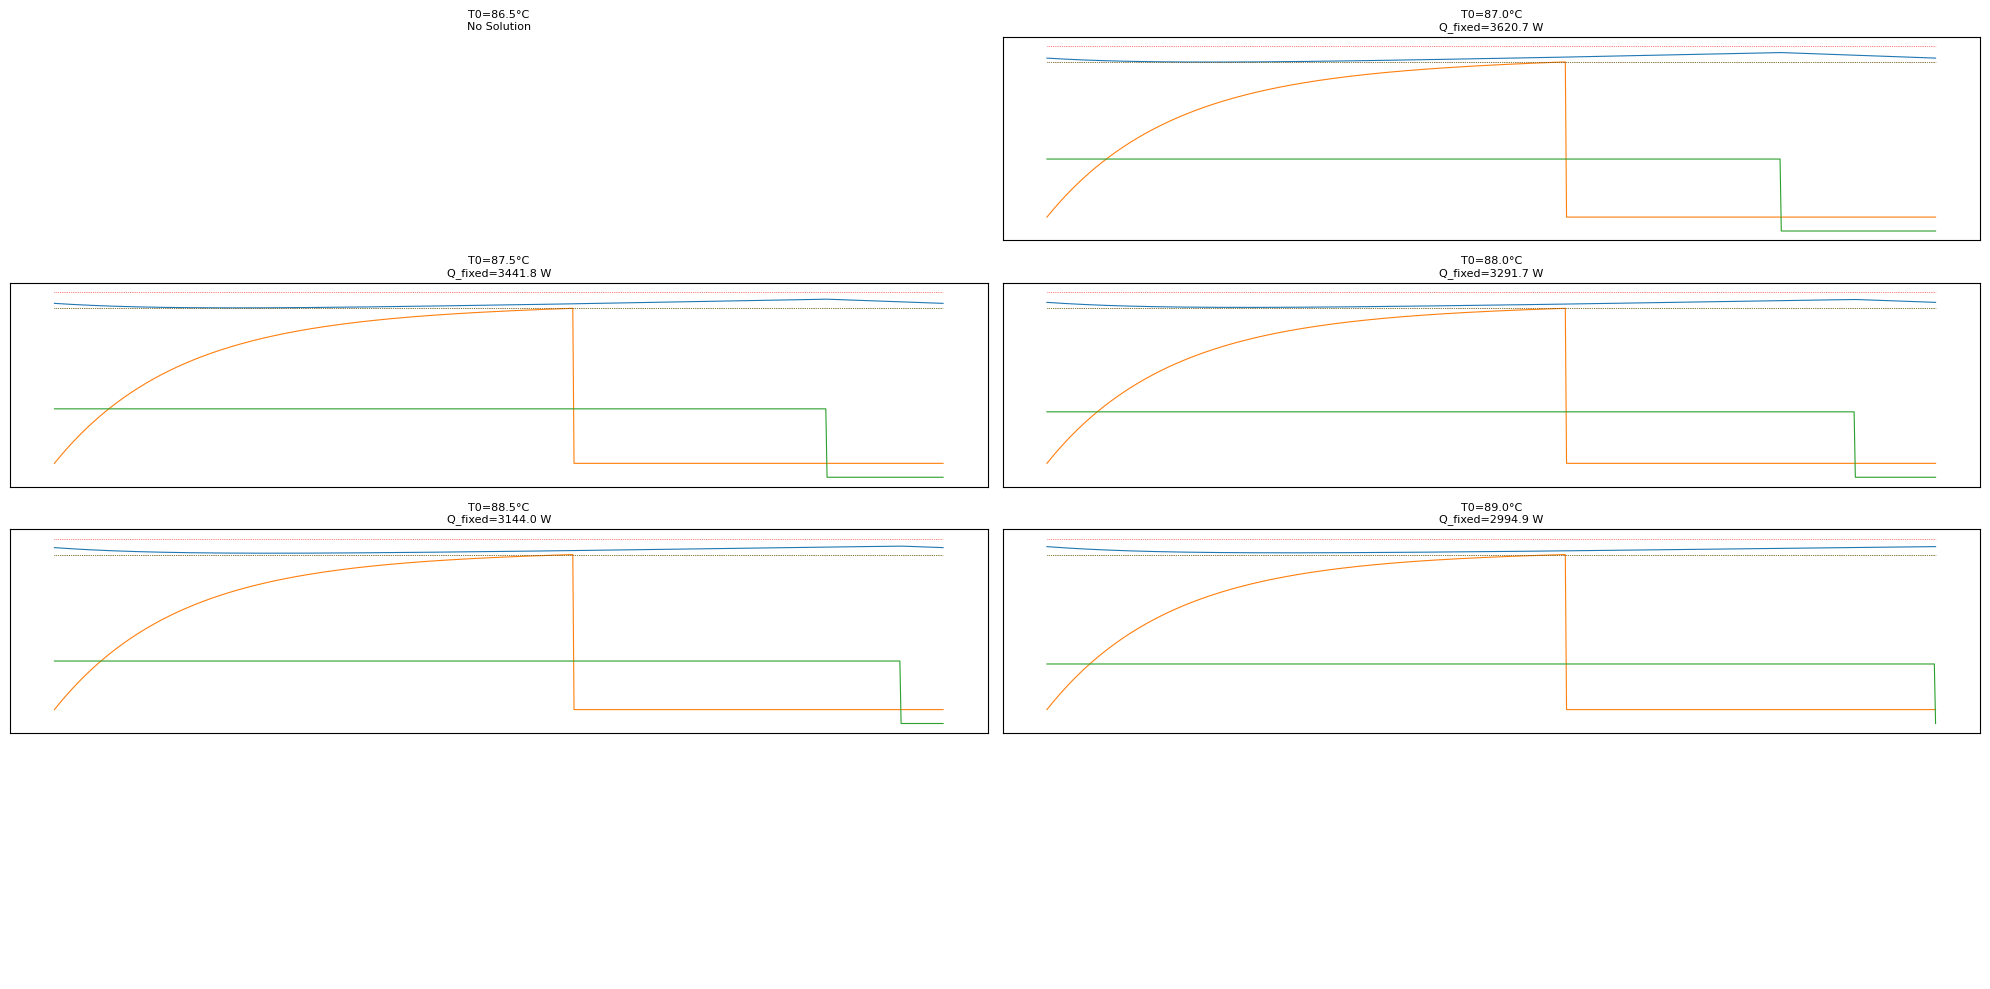

In [5]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Time settings
cook_s = 7 * 60         # Cooking time (with pasta)
cool_s = 5 * 60         # Cooling time (no pasta)
dt = 1
n_cook = int(cook_s / dt)
n_cool = int(cool_s / dt)
n_total = n_cook + n_cool + 1

T_env = 20
T_pasta_0 = 7

# System properties
R_env = 30 / 1000    # [K/W]
R_pasta = 15 / 1000  # [K/W]
c_l = 4.18 * 1000    # [J/kg·K]
c_pasta = 3.5 * 1000 # [J/kg·K]

V_water = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1e6  # m^3
m_water = V_water * 1000
m_pasta = 2

C_water = m_water * c_l
C_pasta = m_pasta * c_pasta

t = np.linspace(0, cook_s + cool_s, n_total)
T_water_0_range = np.arange(86.5, 89.5, 0.5)
Q_fixed_values = []

fig, axs = plt.subplots(4, int(np.ceil(len(T_water_0_range) / 4)), figsize=(20, 10))
axs = axs.flatten()

for idx, T_water_0 in enumerate(T_water_0_range):
    model = gp.Model("HeatPumpCooking")
    model.setParam("OutputFlag", 0)

    Q_fixed = model.addVar(lb=0, ub=10000, name="Q_fixed")
    z = model.addVars(n_total, vtype=GRB.BINARY, name="z")
    Q = model.addVars(n_total, lb=0, name="Q")
    delta_on = model.addVars(n_total, vtype=GRB.BINARY, name="delta_on")
    T_water = model.addVars(n_total, lb=0, name="T_water")
    T_pasta = model.addVars(n_total, lb=0, name="T_pasta")

    model.addConstr(T_water[0] == T_water_0)
    model.addConstr(T_pasta[0] == T_pasta_0)

    # Heat pump only allowed to switch on once
    for t_ in range(1, n_total):
        model.addConstr(delta_on[t_] >= z[t_] - z[t_-1])
        model.addConstr(z[t_] <= z[t_-1])
        model.addConstr(delta_on[t_] >= 0)
        model.addConstr(delta_on[t_] <= 1)

    model.addConstr(gp.quicksum(delta_on[t_] for t_ in range(1, n_total)) <= 1)

    # Link Q to Q_fixed and z
    for i in range(n_total):
        model.addConstr(Q[i] == Q_fixed * z[i])

    # Temperature dynamics
    for i in range(1, n_total):
        if i <= n_cook:
            # Pasta is in water
            model.addConstr(
                T_water[i] == T_water[i - 1] + dt * (
                    Q[i - 1] - (T_water[i - 1] - T_env) / R_env - (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
                ) / C_water
            )
            model.addConstr(
                T_pasta[i] == T_pasta[i - 1] + dt * (
                    (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
                ) / C_pasta
            )
        else:
            # Pasta removed: only water evolves
            model.addConstr(
                T_water[i] == T_water[i - 1] + dt * (
                    Q[i - 1] - (T_water[i - 1] - T_env) / R_env
                ) / C_water
            )
            model.addConstr(T_pasta[i] == 7)  # Pasta temp freezes

    # Constraints
    for i in range(n_total):
        model.addConstr(T_water[i] >= 85)
        model.addConstr(T_water[i] <= 93)

    model.addConstr(T_pasta[n_cook] >= 85)  # Pasta must be done at 7 min
    model.addConstr(T_pasta[n_cook] <= 85.5)
    model.addConstr(T_water[n_total - 1] == T_water_0)


    model.setObjective(gp.quicksum(Q[i] * dt for i in range(n_total)) / 1000, GRB.MINIMIZE)
    model.optimize()

    if model.status == GRB.OPTIMAL:
        Q_vals = np.array([Q[i].X for i in range(n_total)])
        T_water_vals = np.array([T_water[i].X for i in range(n_total)])
        T_pasta_vals = np.array([T_pasta[i].X for i in range(n_total)])
        Q_fixed_val = Q_fixed.X
        Q_fixed_values.append(Q_fixed_val)

        ax = axs[idx]
        ax.plot(t / 60, T_water_vals, label="Water Temp (°C)", linewidth=0.8)
        print(max(T_water_vals))
        ax.plot(t / 60, T_pasta_vals, label="Pasta Temp (°C)", linewidth=0.8)
        ax.plot(t / 60, Q_vals / 100, label="Q (scaled)", linewidth=0.8)
        ax.hlines([85, 93], 0, t[-1] / 60, colors='r', linestyles='dotted', linewidth=0.5)
        ax.hlines([85], 0, t[-1] / 60, colors='g', linestyles='dotted', linewidth=0.5)
        ax.set_title(f"T0={T_water_0:.1f}°C\nQ_fixed={Q_fixed_val:.1f} W", fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(True)
    else:
        Q_fixed_values.append(np.nan)
        axs[idx].set_title(f"T0={T_water_0:.1f}°C\nNo Solution", fontsize=8)
        axs[idx].axis("off")

for ax in axs[len(T_water_0_range):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


### Define Power

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 6487 rows, 3605 columns and 12787 nonzeros
Model fingerprint: 0x788adfcd
Model has 3 quadratic objective terms
Variable types: 2163 continuous, 1442 integer (1442 binary)
Coefficient statistics:
  Matrix range     [1e-05, 3e+03]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-03, 9e+01]
Presolve removed 6327 rows and 3443 columns
Presolve time: 0.65s
Presolved: 160 rows, 162 columns, 478 nonzeros
Presolved model has 3 quadratic objective terms
Variable types: 4 continuous, 158 integer (158 binary)
Found heuristic solution: objective 0.0000000

Root relaxation: cutoff, 324 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current 

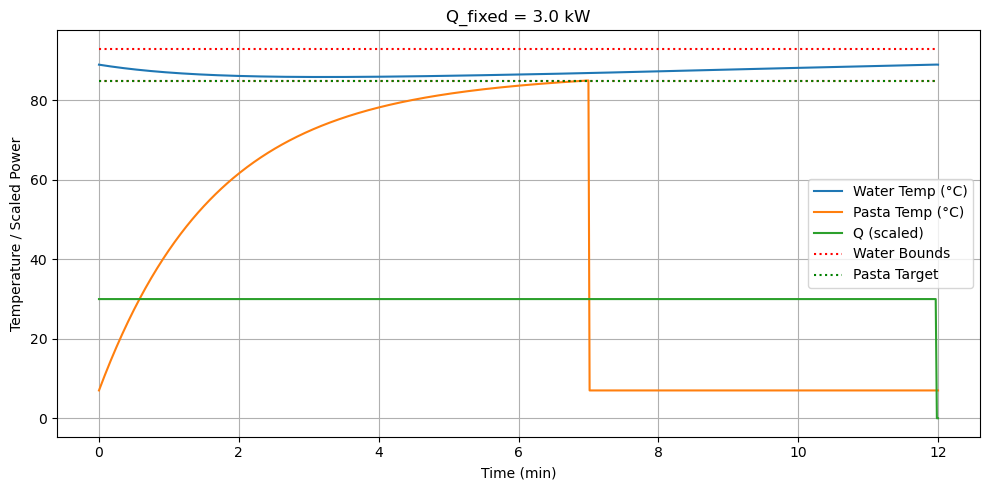

In [31]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Fixierter Wert:
Q_fixed_val = 3000  # Watt

# Time settings
cook_s = 7 * 60
cool_s = 5 * 60
dt = 1
n_cook = int(cook_s / dt)
n_cool = int(cool_s / dt)
n_total = n_cook + n_cool + 1

T_env = 20
T_pasta_0 = 7

# System properties
R_env = 30 / 1000
R_pasta = 15 / 1000
c_l = 4.18 * 1000
c_pasta = 3.5 * 1000

V_water = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1e6
m_water = V_water * 1000
m_pasta = 2

C_water = m_water * c_l
C_pasta = m_pasta * c_pasta

t = np.linspace(0, cook_s + cool_s, n_total)

# --- Gurobi Model ---
model = gp.Model("FixedQ_TempDecision")
model.setParam("OutputFlag", 1)

# Variables
z = model.addVars(n_total, vtype=GRB.BINARY, name="z")
Q = model.addVars(n_total, lb=0, name="Q")
delta_on = model.addVars(n_total, vtype=GRB.BINARY, name="delta_on")
T_water = model.addVars(n_total, lb=0, name="T_water")
T_pasta = model.addVars(n_total, lb=0, name="T_pasta")

# Initial pasta temp
model.addConstr(T_pasta[0] == T_pasta_0)

# Heat pump on only once
for t_ in range(1, n_total):
    model.addConstr(delta_on[t_] >= z[t_] - z[t_-1])
    model.addConstr(z[t_] <= z[t_-1])
    model.addConstr(delta_on[t_] >= 0)
    model.addConstr(delta_on[t_] <= 1)

model.addConstr(gp.quicksum(delta_on[t_] for t_ in range(1, n_total)) <= 1)

# Q is fixed value when on
for i in range(n_total):
    model.addConstr(Q[i] == Q_fixed_val * z[i])

# Dynamics
for i in range(1, n_total):
    if i <= n_cook:
        model.addConstr(
            T_water[i] == T_water[i - 1] + dt * (
                Q[i - 1] - (T_water[i - 1] - T_env) / R_env - (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_water
        )
        model.addConstr(
            T_pasta[i] == T_pasta[i - 1] + dt * (
                (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_pasta
        )
    else:
        model.addConstr(
            T_water[i] == T_water[i - 1] + dt * (
                Q[i - 1] - (T_water[i - 1] - T_env) / R_env
            ) / C_water
        )
        model.addConstr(T_pasta[i] == 7)

# Temperature bounds
for i in range(n_total):
    model.addConstr(T_water[i] >= 85)
    model.addConstr(T_water[i] <= 93)

# Pasta ready
model.addConstr(T_pasta[n_cook] >= 85)
model.addConstr(T_pasta[n_cook] <= 85.5)

# Optional: T_water[0] close to T_water[-1] (could also fix one)
model.setObjective((T_water[n_total - 1] - T_water[0]) * (T_water[n_total - 1] - T_water[0]), GRB.MINIMIZE)

model.optimize()


print(max(T_water_vals))
print(T_water_vals[0])
print(T_water_vals[-1])

# Extract results
if model.status == GRB.OPTIMAL:
    Q_vals = np.array([Q[i].X for i in range(n_total)])
    T_water_vals = np.array([T_water[i].X for i in range(n_total)])
    T_pasta_vals = np.array([T_pasta[i].X for i in range(n_total)])

    print(f"Optimal T_water[0]: {T_water[0].X:.2f} °C")
    print(f"Optimal T_water[-1]: {T_water[n_total - 1].X:.2f} °C")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(t / 60, T_water_vals, label="Water Temp (°C)")
    plt.plot(t / 60, T_pasta_vals, label="Pasta Temp (°C)")
    plt.plot(t / 60, Q_vals / 100, label="Q (scaled)")
    plt.hlines([85, 93], 0, t[-1] / 60, colors='r', linestyles='dotted', label="Water Bounds")
    plt.hlines([85], 0, t[-1] / 60, colors='g', linestyles='dotted', label="Pasta Target")
    plt.xlabel("Time (min)")
    plt.ylabel("Temperature / Scaled Power")
    plt.title(f"Q_fixed = {Q_fixed_val / 1000:.1f} kW")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()


In [32]:

print(max(T_water_vals))
print(T_water_vals[0])
print(T_water_vals[-1])

89.02950291647439
89.00707419767697
89.00707419767697


### Flipped so additional solutions can be found

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 6487 rows, 3605 columns and 12787 nonzeros
Model fingerprint: 0x8cf21502
Model has 3 quadratic objective terms
Variable types: 2163 continuous, 1442 integer (1442 binary)
Coefficient statistics:
  Matrix range     [1e-05, 4e+03]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-03, 9e+01]


Presolve removed 6433 rows and 3550 columns
Presolve time: 0.44s
Presolved: 54 rows, 55 columns, 183 nonzeros
Presolved model has 3 quadratic objective terms
Variable types: 31 continuous, 24 integer (24 binary)
Found heuristic solution: objective 0.8805408
Found heuristic solution: objective 0.0021284

Root relaxation: objective 0.000000e+00, 114 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   24    0.00213    0.00000   100%     -    0s
     0     0    0.00000    0   23    0.00213    0.00000   100%     -    0s
     0     0    0.00000    0   22    0.00213    0.00000   100%     -    0s
H    0     0                       0.0000018    0.00000   100%     -    0s
     0     2    0.00000    0   22    0.00000    0.00000   100%     -    0s

Explored 13 nodes (254 simplex iterations) in 0.76 seconds (0.09 work units)
Th

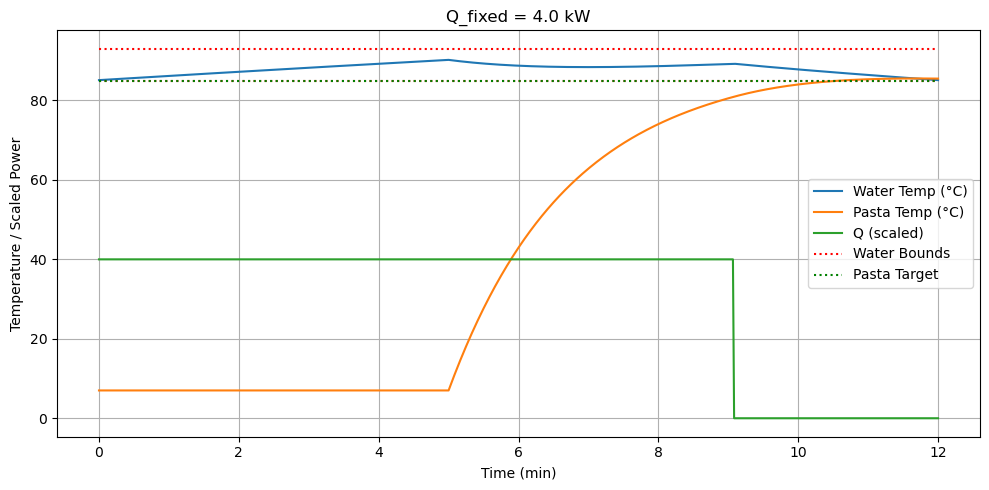

In [22]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Fixierter Wert:
Q_fixed_val = 4000  # Watt

# Time settings
cook_s = 7 * 60
cool_s = 5 * 60
dt = 1
n_cook = int(cook_s / dt)
n_cool = int(cool_s / dt)
n_total = n_cook + n_cool + 1

T_env = 20
T_pasta_0 = 7

# System properties
R_env = 30 / 1000
R_pasta = 15 / 1000
c_l = 4.18 * 1000
c_pasta = 3.5 * 1000

V_water = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1e6
m_water = V_water * 1000
m_pasta = 2

C_water = m_water * c_l
C_pasta = m_pasta * c_pasta

t = np.linspace(0, cook_s + cool_s, n_total)

# --- Gurobi Model ---
model = gp.Model("FixedQ_TempDecision")
model.setParam("OutputFlag", 1)

# Variables
z = model.addVars(n_total, vtype=GRB.BINARY, name="z")
Q = model.addVars(n_total, lb=0, name="Q")
delta_on = model.addVars(n_total, vtype=GRB.BINARY, name="delta_on")
T_water = model.addVars(n_total, lb=0, name="T_water")
T_pasta = model.addVars(n_total, lb=0, name="T_pasta")

# Initial pasta temp
model.addConstr(T_pasta[0] == T_pasta_0)

# Heat pump on only once
for t_ in range(1, n_total):
    model.addConstr(delta_on[t_] >= z[t_] - z[t_-1])
    model.addConstr(z[t_] <= z[t_-1])
    model.addConstr(delta_on[t_] >= 0)
    model.addConstr(delta_on[t_] <= 1)

model.addConstr(gp.quicksum(delta_on[t_] for t_ in range(1, n_total)) <= 1)

# Q is fixed value when on
for i in range(n_total):
    model.addConstr(Q[i] == Q_fixed_val * z[i])

# --- Dynamics (flipped: water-only first, then pasta) ---
for i in range(1, n_total):
    if i <= n_cool:
        # Cooling / water-only phase (first)
        model.addConstr(
            T_water[i] == T_water[i - 1] + dt * (
                Q[i - 1] - (T_water[i - 1] - T_env) / R_env
            ) / C_water
        )
        model.addConstr(T_pasta[i] == 7)
    else:
        # Cooking / pasta phase (second)
        model.addConstr(
            T_water[i] == T_water[i - 1] + dt * (
                Q[i - 1] - (T_water[i - 1] - T_env) / R_env - (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_water
        )
        model.addConstr(
            T_pasta[i] == T_pasta[i - 1] + dt * (
                (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_pasta
        )

# Temperature bounds
for i in range(n_total):
    model.addConstr(T_water[i] >= 85)
    model.addConstr(T_water[i] <= 93)

# Pasta ready at end of cooking
model.addConstr(T_pasta[n_total - 1] >= 85)
model.addConstr(T_pasta[n_total - 1] <= 85.5)

# Objective: minimize difference between initial and final water temperature
model.setObjective((T_water[n_total - 1] - T_water[0]) * (T_water[n_total - 1] - T_water[0]), GRB.MINIMIZE)

model.optimize()

# Extract results
if model.status == GRB.OPTIMAL:
    Q_vals = np.array([Q[i].X for i in range(n_total)])
    T_water_vals = np.array([T_water[i].X for i in range(n_total)])
    T_pasta_vals = np.array([T_pasta[i].X for i in range(n_total)])

    print(f"Optimal T_water[0]: {T_water[0].X:.2f} °C")
    print(f"Optimal T_water[-1]: {T_water[n_total - 1].X:.2f} °C")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(t / 60, T_water_vals, label="Water Temp (°C)")
    plt.plot(t / 60, T_pasta_vals, label="Pasta Temp (°C)")
    plt.plot(t / 60, Q_vals / 100, label="Q (scaled)")
    plt.hlines([85, 93], 0, t[-1] / 60, colors='r', linestyles='dotted', label="Water Bounds")
    plt.hlines([85], 0, t[-1] / 60, colors='g', linestyles='dotted', label="Pasta Target")
    plt.xlabel("Time (min)")
    plt.ylabel("Temperature / Scaled Power")
    plt.title(f"Q_fixed = {Q_fixed_val / 1000:.1f} kW")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()


In [40]:
print(max(T_water_vals[8*60:10*60]))
max(T_water_vals)


86.23981314889245


89.08416711958719

### Missed Pasta adding

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 7027 rows, 3905 columns and 13747 nonzeros
Model fingerprint: 0xae3cc4f5
Model has 3 quadratic objective terms
Variable types: 2343 continuous, 1562 integer (1562 binary)
Coefficient statistics:
  Matrix range     [1e-05, 3e+03]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-03, 9e+01]


Presolve removed 6599 rows and 3475 columns
Presolve time: 1.26s
Presolved: 428 rows, 430 columns, 1472 nonzeros
Presolved model has 3 quadratic objective terms
Variable types: 255 continuous, 175 integer (175 binary)
Found heuristic solution: objective 0.0830298

Root relaxation: objective 0.000000e+00, 1076 iterations, 0.03 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   39    0.08303    0.00000   100%     -    1s
     0     0    0.00000    0   38    0.08303    0.00000   100%     -    1s
     0     0    0.00000    0   38    0.08303    0.00000   100%     -    1s
     0     0    0.00000    0   37    0.08303    0.00000   100%     -    1s
H    0     0                       0.0399962    0.00000   100%     -    1s
H    0     0                       0.0290577    0.00000   100%     -    1s
     0     2    0.00000    0   37    0.02906

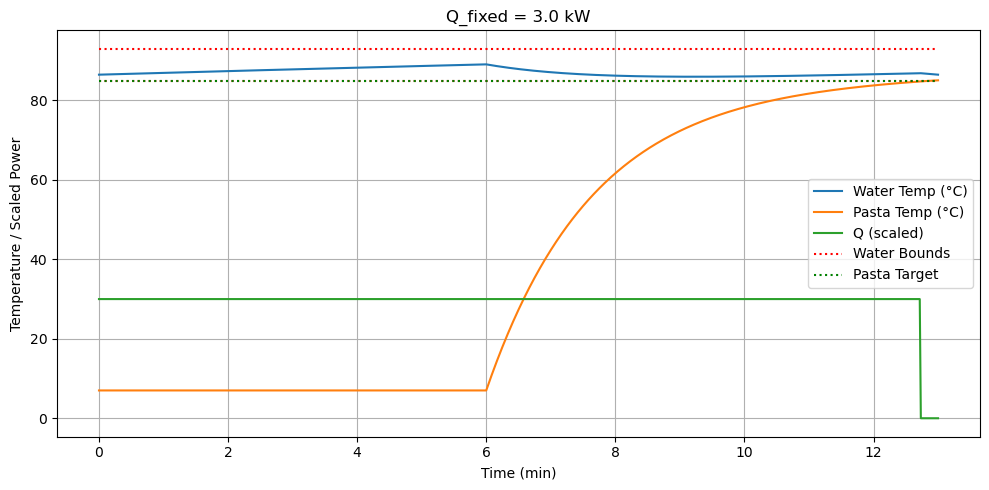

In [3]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Fixierter Wert:
Q_fixed_val = 3000  # Watt

# Time settings
cook_s = 7 * 60
cool_s = 6 * 60
dt = 1
n_cook = int(cook_s / dt)
n_cool = int(cool_s / dt)
n_total = n_cook + n_cool + 1

T_env = 20
T_pasta_0 = 7

# System properties
R_env = 30 / 1000
R_pasta = 15 / 1000
c_l = 4.18 * 1000
c_pasta = 3.5 * 1000

V_water = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1e6
m_water = V_water * 1000
m_pasta = 2

C_water = m_water * c_l
C_pasta = m_pasta * c_pasta

t = np.linspace(0, cook_s + cool_s, n_total)

# --- Gurobi Model ---
model = gp.Model("FixedQ_TempDecision")
model.setParam("OutputFlag", 1)

# Variables
z = model.addVars(n_total, vtype=GRB.BINARY, name="z")
Q = model.addVars(n_total, lb=0, name="Q")
delta_on = model.addVars(n_total, vtype=GRB.BINARY, name="delta_on")
T_water = model.addVars(n_total, lb=0, name="T_water")
T_pasta = model.addVars(n_total, lb=0, name="T_pasta")

# Initial pasta temp
model.addConstr(T_pasta[0] == T_pasta_0)

# Heat pump on only once
for t_ in range(1, n_total):
    model.addConstr(delta_on[t_] >= z[t_] - z[t_-1])
    model.addConstr(z[t_] <= z[t_-1])
    model.addConstr(delta_on[t_] >= 0)
    model.addConstr(delta_on[t_] <= 1)

model.addConstr(gp.quicksum(delta_on[t_] for t_ in range(1, n_total)) <= 1)

# Q is fixed value when on
for i in range(n_total):
    model.addConstr(Q[i] == Q_fixed_val * z[i])

# --- Dynamics (flipped: water-only first, then pasta) ---
for i in range(1, n_total):
    if i <= n_cool:
        # Cooling / water-only phase (first)
        model.addConstr(
            T_water[i] == T_water[i - 1] + dt * (
                Q[i - 1] - (T_water[i - 1] - T_env) / R_env
            ) / C_water
        )
        model.addConstr(T_pasta[i] == 7)
    else:
        # Cooking / pasta phase (second)
        model.addConstr(
            T_water[i] == T_water[i - 1] + dt * (
                Q[i - 1] - (T_water[i - 1] - T_env) / R_env - (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_water
        )
        model.addConstr(
            T_pasta[i] == T_pasta[i - 1] + dt * (
                (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_pasta
        )

# Temperature bounds
for i in range(n_total):
    model.addConstr(T_water[i] >= 85)
    model.addConstr(T_water[i] <= 93)

# Pasta ready at end of cooking
model.addConstr(T_pasta[n_total - 1] >= 85)
model.addConstr(T_pasta[n_total - 1] <= 85.5)

# Objective: minimize difference between initial and final water temperature
model.setObjective((T_water[n_total - 1] - T_water[0]) * (T_water[n_total - 1] - T_water[0]), GRB.MINIMIZE)

model.optimize()

# Extract results
if model.status == GRB.OPTIMAL:
    Q_vals = np.array([Q[i].X for i in range(n_total)])
    T_water_vals = np.array([T_water[i].X for i in range(n_total)])
    T_pasta_vals = np.array([T_pasta[i].X for i in range(n_total)])

    print(f"Optimal T_water[0]: {T_water[0].X:.2f} °C")
    print(f"Optimal T_water[-1]: {T_water[n_total - 1].X:.2f} °C")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(t / 60, T_water_vals, label="Water Temp (°C)")
    plt.plot(t / 60, T_pasta_vals, label="Pasta Temp (°C)")
    plt.plot(t / 60, Q_vals / 100, label="Q (scaled)")
    plt.hlines([85, 93], 0, t[-1] / 60, colors='r', linestyles='dotted', label="Water Bounds")
    plt.hlines([85], 0, t[-1] / 60, colors='g', linestyles='dotted', label="Pasta Target")
    plt.xlabel("Time (min)")
    plt.ylabel("Temperature / Scaled Power")
    plt.title(f"Q_fixed = {Q_fixed_val / 1000:.1f} kW")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 6487 rows, 3605 columns and 12787 nonzeros
Model fingerprint: 0x788adfcd
Model has 3 quadratic objective terms
Variable types: 2163 continuous, 1442 integer (1442 binary)
Coefficient statistics:
  Matrix range     [1e-05, 3e+03]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-03, 9e+01]
Presolve removed 6327 rows and 3443 columns
Presolve time: 0.17s
Presolved: 160 rows, 162 columns, 478 nonzeros
Presolved model has 3 quadratic objective terms
Variable types: 4 continuous, 158 integer (158 binary)
Found heuristic solution: objective 0.0000000

Root relaxation: cutoff, 324 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current 

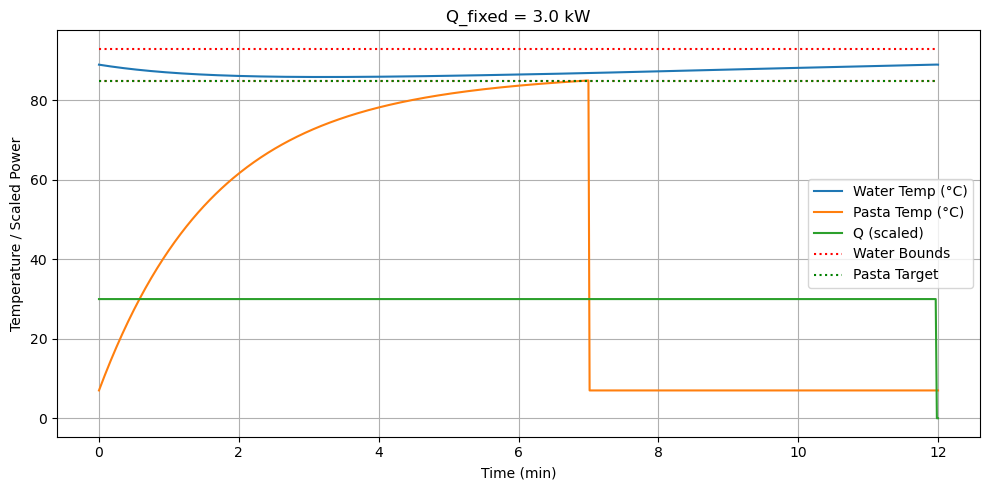

In [4]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Fixierter Wert:
Q_fixed_val = 3000  # Watt

# Time settings
cook_s = 7 * 60
cool_s = 5 * 60
dt = 1
n_cook = int(cook_s / dt)
n_cool = int(cool_s / dt)
n_total = n_cook + n_cool + 1

T_env = 20
T_pasta_0 = 7

# System properties
R_env = 30 / 1000
R_pasta = 15 / 1000
c_l = 4.18 * 1000
c_pasta = 3.5 * 1000

V_water = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1e6
m_water = V_water * 1000
m_pasta = 2

C_water = m_water * c_l
C_pasta = m_pasta * c_pasta

t = np.linspace(0, cook_s + cool_s, n_total)

# --- Gurobi Model ---
model = gp.Model("FixedQ_TempDecision")
model.setParam("OutputFlag", 1)

# Variables
z = model.addVars(n_total, vtype=GRB.BINARY, name="z")
Q = model.addVars(n_total, lb=0, name="Q")
delta_on = model.addVars(n_total, vtype=GRB.BINARY, name="delta_on")
T_water = model.addVars(n_total, lb=0, name="T_water")
T_pasta = model.addVars(n_total, lb=0, name="T_pasta")

# Initial pasta temp
model.addConstr(T_pasta[0] == T_pasta_0)

# Heat pump on only once
for t_ in range(1, n_total):
    model.addConstr(delta_on[t_] >= z[t_] - z[t_-1])
    model.addConstr(z[t_] <= z[t_-1])
    model.addConstr(delta_on[t_] >= 0)
    model.addConstr(delta_on[t_] <= 1)

model.addConstr(gp.quicksum(delta_on[t_] for t_ in range(1, n_total)) <= 1)

# Q is fixed value when on
for i in range(n_total):
    model.addConstr(Q[i] == Q_fixed_val * z[i])

# Dynamics
for i in range(1, n_total):
    if i <= n_cook:
        model.addConstr(
            T_water[i] == T_water[i - 1] + dt * (
                Q[i - 1] - (T_water[i - 1] - T_env) / R_env - (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_water
        )
        model.addConstr(
            T_pasta[i] == T_pasta[i - 1] + dt * (
                (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_pasta
        )
    else:
        model.addConstr(
            T_water[i] == T_water[i - 1] + dt * (
                Q[i - 1] - (T_water[i - 1] - T_env) / R_env
            ) / C_water
        )
        model.addConstr(T_pasta[i] == 7)

# Temperature bounds
for i in range(n_total):
    model.addConstr(T_water[i] >= 85)
    model.addConstr(T_water[i] <= 93)

# Pasta ready
model.addConstr(T_pasta[n_cook] >= 85)
model.addConstr(T_pasta[n_cook] <= 85.5)

# Optional: T_water[0] close to T_water[-1] (could also fix one)
model.setObjective((T_water[n_total - 1] - T_water[0]) * (T_water[n_total - 1] - T_water[0]), GRB.MINIMIZE)

model.optimize()


print(max(T_water_vals))
print(T_water_vals[0])
print(T_water_vals[-1])

# Extract results
if model.status == GRB.OPTIMAL:
    Q_vals = np.array([Q[i].X for i in range(n_total)])
    T_water_vals = np.array([T_water[i].X for i in range(n_total)])
    T_pasta_vals = np.array([T_pasta[i].X for i in range(n_total)])

    print(f"Optimal T_water[0]: {T_water[0].X:.2f} °C")
    print(f"Optimal T_water[-1]: {T_water[n_total - 1].X:.2f} °C")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(t / 60, T_water_vals, label="Water Temp (°C)")
    plt.plot(t / 60, T_pasta_vals, label="Pasta Temp (°C)")
    plt.plot(t / 60, Q_vals / 100, label="Q (scaled)")
    plt.hlines([85, 93], 0, t[-1] / 60, colors='r', linestyles='dotted', label="Water Bounds")
    plt.hlines([85], 0, t[-1] / 60, colors='g', linestyles='dotted', label="Pasta Target")
    plt.xlabel("Time (min)")
    plt.ylabel("Temperature / Scaled Power")
    plt.title(f"Q_fixed = {Q_fixed_val / 1000:.1f} kW")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()


Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 12969 rows, 7205 columns and 25569 nonzeros
Model fingerprint: 0xb7819d2e
Model has 1 quadratic objective term
Variable types: 4323 continuous, 2882 integer (2882 binary)
Coefficient statistics:
  Matrix range     [1e-05, 3e+03]
  Objective range  [2e+02, 2e+02]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-03, 9e+01]
Presolve removed 12815 rows and 7049 columns
Presolve time: 0.21s
Presolved: 154 rows, 156 columns, 461 nonzeros
Presolved model has 1 quadratic objective terms
Variable types: 3 continuous, 153 integer (153 binary)
Found heuristic solution: objective 63.4664820
Found heuristic solution: objective 13.3829936

Root relaxation: objective 1.316990e+01, 311 itera

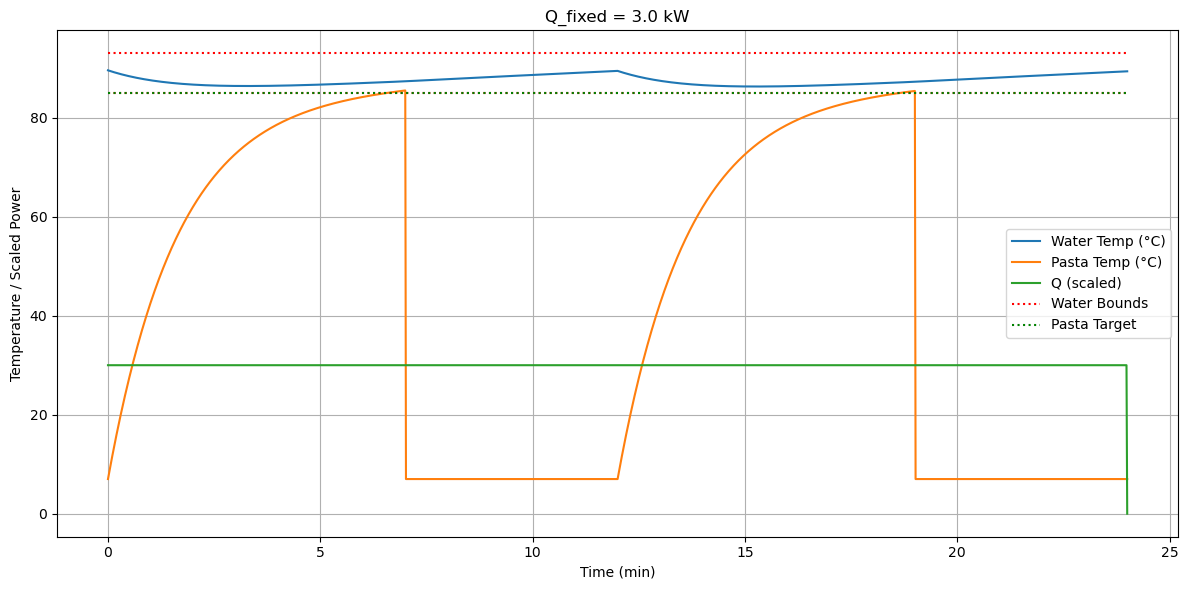

In [5]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Fixed heating power
Q_fixed_val = 3000  # Watt

# Time settings
cook_s = 7 * 60
cool_s = 5 * 60
dt = 1
n_cook = int(cook_s / dt)
n_cool = int(cool_s / dt)
n_total = 2 * (n_cook + n_cool) + 1  # Two cooking and two cooling phases

# Environment and initial temps
T_env = 20
T_pasta_0 = 7

# System properties
R_env = 30 / 1000
R_pasta = 15 / 1000
c_l = 4.18 * 1000
c_pasta = 3.5 * 1000

V_water = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1e6  # m³
m_water = V_water * 1000  # kg (assuming 1 kg/L)
m_pasta = 2  # kg

C_water = m_water * c_l
C_pasta = m_pasta * c_pasta

# Time array
t = np.linspace(0, 2 * (cook_s + cool_s), n_total)

# Gurobi model
model = gp.Model("TwoCookingPhases_OneHeaterOn")
model.setParam("OutputFlag", 1)

# Variables
z = model.addVars(n_total, vtype=GRB.BINARY, name="z")
Q = model.addVars(n_total, lb=0, name="Q")
delta_on = model.addVars(n_total, vtype=GRB.BINARY, name="delta_on")
T_water = model.addVars(n_total, lb=0, name="T_water")
T_pasta = model.addVars(n_total, lb=0, name="T_pasta")

# Initial condition
model.addConstr(T_pasta[0] == T_pasta_0)

# Ensure heater is turned on only once
for t_ in range(1, n_total):
    model.addConstr(delta_on[t_] >= z[t_] - z[t_ - 1])
    model.addConstr(z[t_] <= z[t_ - 1])
    model.addConstr(delta_on[t_] >= 0)
    model.addConstr(delta_on[t_] <= 1)

model.addConstr(gp.quicksum(delta_on[t_] for t_ in range(1, n_total)) <= 1)

# Q only when heater is on
for i in range(n_total):
    model.addConstr(Q[i] == Q_fixed_val * z[i])

# Dynamics
for i in range(1, n_total):
    # Determine if we are in a cooking or cooling phase
    in_first_cook = i <= n_cook
    in_second_cook = (n_cook + n_cool) < i <= (2 * n_cook + n_cool)
    
    if in_first_cook or in_second_cook:
        model.addConstr(
            T_water[i] == T_water[i - 1] + dt * (
                Q[i - 1] - (T_water[i - 1] - T_env) / R_env - (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_water
        )
        model.addConstr(
            T_pasta[i] == T_pasta[i - 1] + dt * (
                (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_pasta
        )
    else:
        # Cooling phase: assume new pasta is added at 7°C
        model.addConstr(
            T_water[i] == T_water[i - 1] + dt * (
                Q[i - 1] - (T_water[i - 1] - T_env) / R_env
            ) / C_water
        )
        model.addConstr(T_pasta[i] == 7)

# Temperature constraints
for i in range(n_total):
    model.addConstr(T_water[i] >= 85)
    model.addConstr(T_water[i] <= 93)

# Pasta must be cooked at the end of both cooking phases
model.addConstr(T_pasta[n_cook] >= 85)
model.addConstr(T_pasta[n_cook] <= 85.5)
model.addConstr(T_pasta[2 * n_cook + n_cool] >= 85)
model.addConstr(T_pasta[2 * n_cook + n_cool] <= 85.5)

# Optional: water temp final close to initial
model.setObjective((T_water[n_total - 1] - T_water_0) ** 2, GRB.MINIMIZE)

# Solve
model.optimize()

# Extract and plot results
if model.status == GRB.OPTIMAL:
    Q_vals = np.array([Q[i].X for i in range(n_total)])
    T_water_vals = np.array([T_water[i].X for i in range(n_total)])
    T_pasta_vals = np.array([T_pasta[i].X for i in range(n_total)])

    print(f"Optimal T_water[0]: {T_water[0].X:.2f} °C")
    print(f"Optimal T_water[-1]: {T_water[n_total - 1].X:.2f} °C")

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(t / 60, T_water_vals, label="Water Temp (°C)")
    plt.plot(t / 60, T_pasta_vals, label="Pasta Temp (°C)")
    plt.plot(t / 60, Q_vals / 100, label="Q (scaled)")
    plt.hlines([85, 93], 0, t[-1] / 60, colors='r', linestyles='dotted', label="Water Bounds")
    plt.hlines([85], 0, t[-1] / 60, colors='g', linestyles='dotted', label="Pasta Target")
    plt.xlabel("Time (min)")
    plt.ylabel("Temperature / Scaled Power")
    plt.title(f"Q_fixed = {Q_fixed_val / 1000:.1f} kW")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) Ultra 7 155H, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 22 logical processors, using up to 22 threads

Optimize a model with 7208 rows, 5764 columns and 14049 nonzeros
Model fingerprint: 0xc07c6484
Model has 3 quadratic objective terms
Variable types: 4323 continuous, 1441 integer (1441 binary)
Coefficient statistics:
  Matrix range     [1e-05, 3e+03]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-03, 9e+01]
Presolve removed 5860 rows and 2975 columns
Presolve time: 0.02s
Presolved: 1348 rows, 2789 columns, 5829 nonzeros
Presolved model has 3 quadratic objective terms
Variable types: 1349 continuous, 1440 integer (1440 binary)

Root relaxation: objective -2.912251e-17, 6449 iterations, 0.09 seconds (0.20 work units)

    Nodes    |    Curren

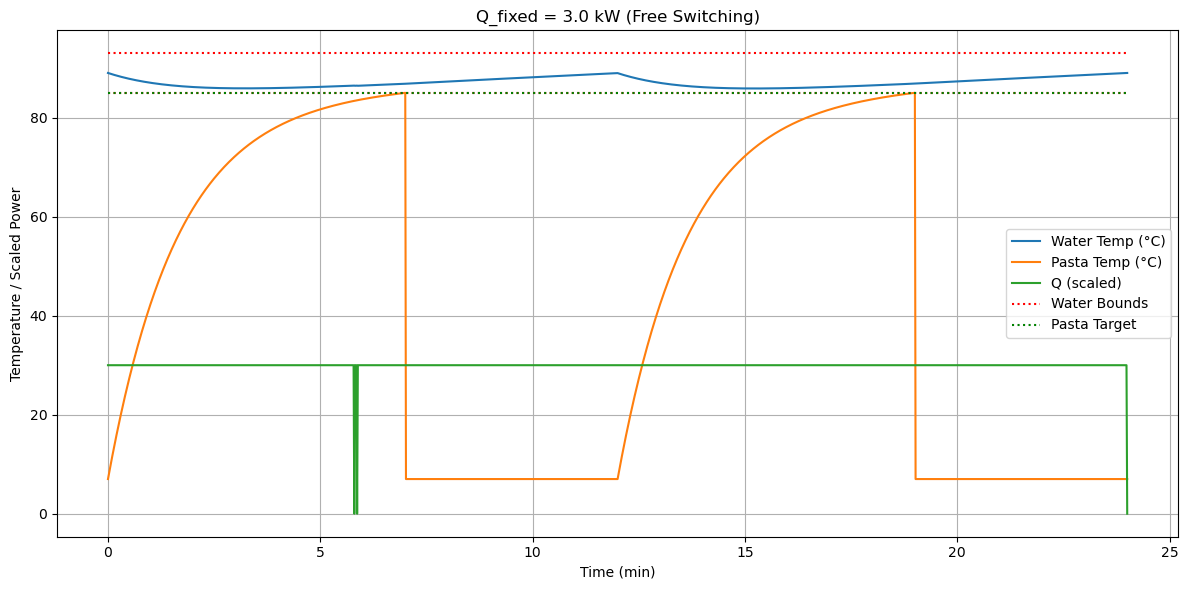

In [13]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Fixed heating power
Q_fixed_val = 3000  # Watt

# Time settings
cook_s = 7 * 60
cool_s = 5 * 60
dt = 1
n_cook = int(cook_s / dt)
n_cool = int(cool_s / dt)
n_total = 2 * (n_cook + n_cool) + 1  # Two cooking and two cooling phases

# Environment and initial temps
T_env = 20
T_pasta_0 = 7

# System properties
R_env = 30 / 1000
R_pasta = 15 / 1000
c_l = 4.18 * 1000
c_pasta = 3.5 * 1000

V_water = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1e6  # m³
m_water = V_water * 1000  # kg (assuming 1 kg/L)
m_pasta = 2  # kg

C_water = m_water * c_l
C_pasta = m_pasta * c_pasta

# Time array
t = np.linspace(0, 2 * (cook_s + cool_s), n_total)

# Gurobi model
model = gp.Model("TwoCookingPhases_FreeHeaterControl")
model.setParam("OutputFlag", 1)

# Variables
z = model.addVars(n_total, vtype=GRB.BINARY, name="z")
Q = model.addVars(n_total, lb=0, name="Q")
T_water = model.addVars(n_total, lb=0, name="T_water")
T_pasta = model.addVars(n_total, lb=0, name="T_pasta")

# Initial pasta temperature
model.addConstr(T_pasta[0] == T_pasta_0)

# Q is fixed when heater is on
for i in range(n_total):
    model.addConstr(Q[i] == Q_fixed_val * z[i])

# Dynamics
for i in range(1, n_total):
    # Determine if we are in a cooking or cooling phase
    in_first_cook = i <= n_cook
    in_second_cook = (n_cook + n_cool) < i <= (2 * n_cook + n_cool)

    if in_first_cook or in_second_cook:
        model.addConstr(
            T_water[i] == T_water[i - 1] + dt * (
                Q[i - 1] - (T_water[i - 1] - T_env) / R_env - (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_water
        )
        model.addConstr(
            T_pasta[i] == T_pasta[i - 1] + dt * (
                (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_pasta
        )
    else:
        # Cooling phase: reset pasta to 7°C (new pasta)
        model.addConstr(
            T_water[i] == T_water[i - 1] + dt * (
                Q[i - 1] - (T_water[i - 1] - T_env) / R_env
            ) / C_water
        )
        model.addConstr(T_pasta[i] == 7)

# Temperature constraints
for i in range(n_total):
    model.addConstr(T_water[i] >= 85)
    model.addConstr(T_water[i] <= 93)

# Pasta cooking completion after both cooking phases
model.addConstr(T_pasta[n_cook] >= 85)
model.addConstr(T_pasta[n_cook] <= 85.5)
model.addConstr(T_pasta[2 * n_cook + n_cool] >= 85)
model.addConstr(T_pasta[2 * n_cook + n_cool] <= 85.5)

# Optional: minimize water temperature difference from start to end
model.setObjective((T_water[n_total - 1] - T_water[0]) ** 2, GRB.MINIMIZE)

# Solve
model.optimize()

# Extract and plot results
if model.status == GRB.OPTIMAL:
    Q_vals = np.array([Q[i].X for i in range(n_total)])
    T_water_vals = np.array([T_water[i].X for i in range(n_total)])
    T_pasta_vals = np.array([T_pasta[i].X for i in range(n_total)])

    print(f"Optimal T_water[0]: {T_water[0].X:.2f} °C")
    print(f"Optimal T_water[-1]: {T_water[n_total - 1].X:.2f} °C")

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(t / 60, T_water_vals, label="Water Temp (°C)")
    plt.plot(t / 60, T_pasta_vals, label="Pasta Temp (°C)")
    plt.plot(t / 60, Q_vals / 100, label="Q (scaled)")
    plt.hlines([85, 93], 0, t[-1] / 60, colors='r', linestyles='dotted', label="Water Bounds")
    plt.hlines([85], 0, t[-1] / 60, colors='g', linestyles='dotted', label="Pasta Target")
    plt.xlabel("Time (min)")
    plt.ylabel("Temperature / Scaled Power")
    plt.title(f"Q_fixed = {Q_fixed_val / 1000:.1f} kW (Free Switching)")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

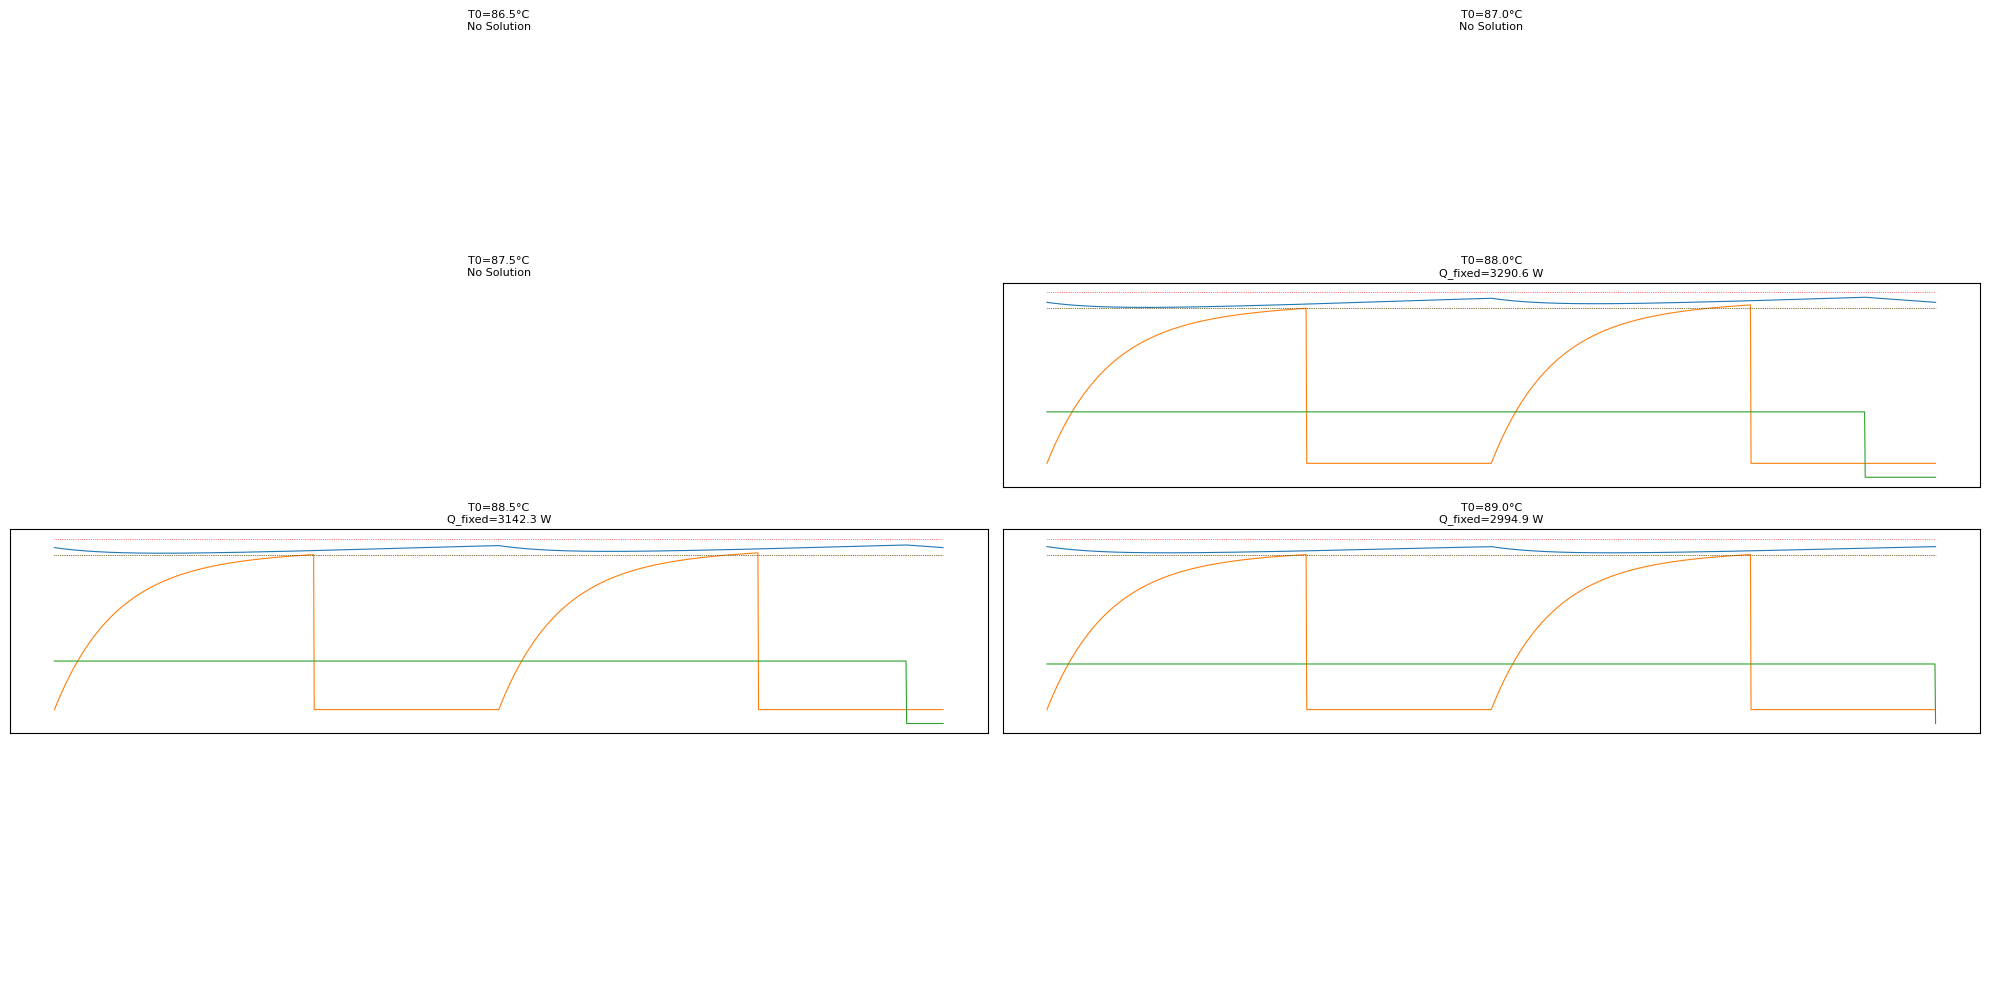

In [21]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Time settings
cook_s = 7 * 60
cool_s = 5 * 60
dt = 1
n_cook = int(cook_s / dt)
n_cool = int(cool_s / dt)
n_total = 2 * (n_cook + n_cool) + 1  # Two cycles

T_env = 20
T_pasta_0 = 7

# System properties
R_env = 30 / 1000
R_pasta = 15 / 1000
c_l = 4.18 * 1000
c_pasta = 3.5 * 1000

V_water = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1e6  # m³
m_water = V_water * 1000
m_pasta = 2

C_water = m_water * c_l
C_pasta = m_pasta * c_pasta

t = np.linspace(0, 2 * (cook_s + cool_s), n_total)
T_water_0_range = np.arange(86.5, 89.5, 0.5)
Q_fixed_values = []

fig, axs = plt.subplots(4, int(np.ceil(len(T_water_0_range) / 4)), figsize=(20, 10))
axs = axs.flatten()

for idx, T_water_0 in enumerate(T_water_0_range):
    model = gp.Model("TwoCycleHeatPump_OneSwitch")
    model.setParam("OutputFlag", 0)

    Q_fixed = model.addVar(lb=0, ub=10000, name="Q_fixed")
    z = model.addVars(n_total, vtype=GRB.BINARY, name="z")
    Q = model.addVars(n_total, lb=0, name="Q")
    delta_on = model.addVars(n_total, vtype=GRB.BINARY, name="delta_on")
    T_water = model.addVars(n_total, lb=0, name="T_water")
    T_pasta = model.addVars(n_total, lb=0, name="T_pasta")

    # Initial conditions
    model.addConstr(T_water[0] == T_water_0)
    model.addConstr(T_pasta[0] == T_pasta_0)

    # Link heater power to binary state
    for i in range(n_total):
        model.addConstr(Q[i] == Q_fixed * z[i])

    # Heater switching constraints (only 1 switch-on allowed)
    for t_ in range(1, n_total):
        model.addConstr(delta_on[t_] >= z[t_] - z[t_ - 1])
        model.addConstr(z[t_] <= z[t_ - 1])
        model.addConstr(delta_on[t_] >= 0)
        model.addConstr(delta_on[t_] <= 1)

    model.addConstr(gp.quicksum(delta_on[t_] for t_ in range(1, n_total)) <= 1)

    # System dynamics
    for i in range(1, n_total):
        in_first_cook = i <= n_cook
        in_second_cook = (n_cook + n_cool) < i <= (2 * n_cook + n_cool)

        if in_first_cook or in_second_cook:
            model.addConstr(
                T_water[i] == T_water[i - 1] + dt * (
                    Q[i - 1] - (T_water[i - 1] - T_env) / R_env - (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
                ) / C_water
            )
            model.addConstr(
                T_pasta[i] == T_pasta[i - 1] + dt * (
                    (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
                ) / C_pasta
            )
        else:
            model.addConstr(
                T_water[i] == T_water[i - 1] + dt * (
                    Q[i - 1] - (T_water[i - 1] - T_env) / R_env
                ) / C_water
            )
            model.addConstr(T_pasta[i] == 7)  # New pasta inserted

    # Temperature bounds
    for i in range(n_total):
        model.addConstr(T_water[i] >= 85)
        model.addConstr(T_water[i] <= 100)

    # Cooking quality constraints
    model.addConstr(T_pasta[n_cook] >= 85)
    model.addConstr(T_pasta[n_cook] <= 87)
    model.addConstr(T_pasta[2 * n_cook + n_cool] >= 85)
    model.addConstr(T_pasta[2 * n_cook + n_cool] <= 87)

    # Final water temp = initial temp
    model.addConstr(T_water[n_total - 1] == T_water_0)

    # Objective: minimize energy in kJ
    model.setObjective(gp.quicksum(Q[i] * dt for i in range(n_total)) / 1000, GRB.MINIMIZE)

    model.optimize()

    if model.status == GRB.OPTIMAL:
        Q_vals = np.array([Q[i].X for i in range(n_total)])
        T_water_vals = np.array([T_water[i].X for i in range(n_total)])
        T_pasta_vals = np.array([T_pasta[i].X for i in range(n_total)])
        Q_fixed_val = Q_fixed.X
        Q_fixed_values.append(Q_fixed_val)

        ax = axs[idx]
        ax.plot(t / 60, T_water_vals, label="Water Temp (°C)", linewidth=0.8)
        ax.plot(t / 60, T_pasta_vals, label="Pasta Temp (°C)", linewidth=0.8)
        ax.plot(t / 60, Q_vals / 100, label="Q (scaled)", linewidth=0.8)
        ax.hlines([85, 93], 0, t[-1] / 60, colors='r', linestyles='dotted', linewidth=0.5)
        ax.hlines([85], 0, t[-1] / 60, colors='g', linestyles='dotted', linewidth=0.5)
        ax.set_title(f"T0={T_water_0:.1f}°C\nQ_fixed={Q_fixed_val:.1f} W", fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(True)
    else:
        Q_fixed_values.append(np.nan)
        axs[idx].set_title(f"T0={T_water_0:.1f}°C\nNo Solution", fontsize=8)
        axs[idx].axis("off")

# Turn off unused subplots
for ax in axs[len(T_water_0_range):]:
    ax.axis("off")

plt.tight_layout()
plt.show()